# Part 0: Load in Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import localcider
from localcider.sequenceParameters import SequenceParameters
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from scipy.stats import fisher_exact


# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Get number of IDRs per GIN type

## 1.1 - Load in IDRome data

In [2]:
humandf=pd.read_excel('../general_data/All_sapiens_IDRs_clustermap_using_centroids.xlsx')

print(humandf.isnull().any())
humandf = humandf.fillna('')

fullaccs=humandf['Uniprot'].tolist()
fullaccswnums=humandf['Uniprot w IDRnum'].tolist()
fullgeneswnums=humandf['Gene'].tolist()
fullclusternum=humandf['Cluster Number'].tolist()
fullseqlens=humandf['IDR Length'].tolist()
fullstpos=humandf['Start Pos'].tolist()
fullenpos=humandf['End Pos'].tolist()
fullproteinlength=humandf['Full Protein Length'].tolist()
fullmininterclustdist=humandf['Min Inter Clust Dist'].tolist()
fulltermini=humandf['IDR Position'].tolist()
fulllocationbyunistring=humandf['HPA Location'].tolist()
fullseqs=humandf['Sequence'].tolist()

print(humandf)


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location             True
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
1               1  Q9NRJ4         Q9NRJ4_1      TULP4 IDR1              17   
2               2  Q9NRJ4         Q9NRJ4_2      TULP4 IDR2               1   
3               3  Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              27   
4               4  Q9NRJ4         Q9NRJ4_4      TULP4 IDR4              27   
...           ...     ...              ...             ...             ...   
24503       24503  Q7Z739         Q7Z739_2     YTHDF

## 1.2 - Plot number of clusters by GIN type

[561, 718, 163, 1097, 1537, 254, 1833, 763, 187, 939, 575, 338, 434, 579, 507, 539, 610, 1739, 413, 1375, 803, 225, 142, 1043, 1810, 1234, 454, 1386, 768, 1482]
[22  2  8 21  5 11 18 12 26 14 15  0 10 13 16  1  7 28 20  9 23  3 25 19
 27 29  4 17 24  6]


(0.25, 30.75)

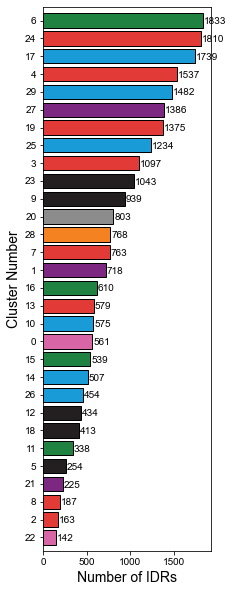

In [3]:
numkclusts=max(fullclusternum)+1
colorhex=['#d865a6','#7c2880','#e23a36','#e23a36','#e23a36','#231f20','#1f8241','#e23a36','#e23a36','#231f20','#189bd7','#1f8241','#231f20','#e23a36','#189bd7','#1f8241','#1f8241','#189bd7','#231f20','#e23a36','#8c8c8c','#7c2880','#d865a6','#231f20','#e23a36','#189bd7','#189bd7','#7c2880','#f58220','#189bd7']

fullhumancount=[]
for c in range(0,numkclusts):
    fullhumancount.append(fullclusternum.count(c))
    
print(fullhumancount)

tmp = np.argsort(fullhumancount)
sort_index2 = tmp #[::-1] 
print(sort_index2)

plt.figure(figsize=(3,10))
count=0
for s in sort_index2:
    count=count+1
    plt.barh(count,fullhumancount[s],color=colorhex[s],edgecolor='black')
    plt.text(fullhumancount[s]+10,count-0.2,str(fullhumancount[s]))
    
plt.yticks(np.arange(1,len(sort_index2)+1,1),sort_index2)
plt.ylabel('Cluster Number',fontsize=14)
plt.xlabel('Number of IDRs',fontsize=14)
plt.ylim([0.25,numkclusts+0.75])

#plt.savefig('Figures/2024_02/Number_in_Clusters_all_human_IDRome.pdf', transparent=False, bbox_inches = "tight")

## 1.3 - Save data to excel file

In [4]:
myclustorder=[7, 3, 13, 2, 8, 19, 4, 24, 18, 12, 5, 9, 23, 14, 25, 26, 29, 17, 10, 1, 21, 27, 22, 0, 20, 16, 11, 15, 6, 28]

cfullhumancount=[]
for i in range(0,len(myclustorder)):
    cfullhumancount.append(fullhumancount[myclustorder[i]])

dfcount=pd.DataFrame()
dfcount['GIN Type']=myclustorder
dfcount['Number of IDRs']=cfullhumancount
print(dfcount)

#with pd.ExcelWriter('../Supplementary_Tables/Table_S1.xlsx', engine='openpyxl',mode='a') as writer:
#    dfcount.to_excel(writer,sheet_name='Fig_S1C')

    GIN Type  Number of IDRs
0          7             763
1          3            1097
2         13             579
3          2             163
4          8             187
5         19            1375
6          4            1537
7         24            1810
8         18             413
9         12             434
10         5             254
11         9             939
12        23            1043
13        14             507
14        25            1234
15        26             454
16        29            1482
17        17            1739
18        10             575
19         1             718
20        21             225
21        27            1386
22        22             142
23         0             561
24        20             803
25        16             610
26        11             338
27        15             539
28         6            1833
29        28             768


[6.210175168167112, 6.530258743009412, 7.688897566110697, 4.440860529763718, 3.886777803314885, 6.400244332776442, 4.463914429611926, 10.94799738610497, 8.494626223734116, 4.084419694330411, 5.193754665801613, 9.700393665609582, 4.347816166813061, 5.812134502268961, 6.037486113998867, 9.241109762815807, 3.8122075422198805, 3.871513913207618, 6.340318465255557, 5.820033399155566, 7.956724003327984, 9.5780620504718, 46.53304525501342, 10.60649376143641, 3.235091725759643, 3.259832180817078, 12.356490358977135, 4.4684263118813625, 6.021422837366556, 4.244075948210295]
[28, 6, 15, 11, 16, 20, 0, 22, 27, 21, 1, 10, 17, 29, 26, 25, 14, 23, 9, 5, 12, 18, 24, 4, 19, 8, 2, 13, 3, 7]


(0.25, 30.75)

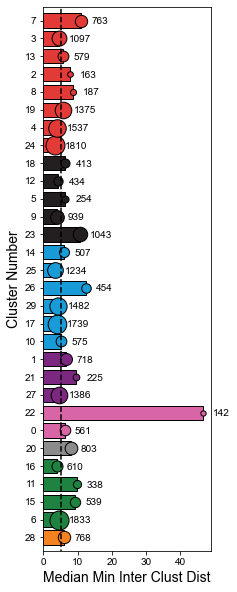

In [5]:
numkclusts=max(fullclusternum)+1
colorhex=['#d865a6','#7c2880','#e23a36','#e23a36','#e23a36','#231f20','#1f8241','#e23a36','#e23a36','#231f20','#189bd7','#1f8241','#231f20','#e23a36','#189bd7','#1f8241','#1f8241','#189bd7','#231f20','#e23a36','#8c8c8c','#7c2880','#d865a6','#231f20','#e23a36','#189bd7','#189bd7','#7c2880','#f58220','#189bd7']

fullhumangoodness=[]
for c in range(0,numkclusts):
    tmpdf=humandf[humandf['Cluster Number']==c]
    fullhumangoodness.append(np.median(tmpdf['Min Inter Clust Dist'].tolist()))
    
print(fullhumangoodness)

tmp = np.argsort(fullhumangoodness)
#sort_index2 = tmp #[::-1] 
sort_index2=[28, 6, 15, 11, 16, 20, 0, 22, 27, 21, 1, 10, 17, 29, 26, 25, 14, 23, 9, 5, 12, 18, 24, 4, 19, 8, 2, 13, 3, 7]
print(sort_index2)

plt.figure(figsize=(3,10))
count=0
for s in sort_index2:
    count=count+1
    plt.barh(count,fullhumangoodness[s],color=colorhex[s],edgecolor='black')
    plt.scatter(fullhumangoodness[s],count,color=colorhex[s],edgecolor='black',s=fullhumancount[s]/5)
    #plt.text(fullhumangoodness[s]+2,count-0.2,str(round(fullhumangoodness[s],1)))
    plt.text(fullhumangoodness[s]+3,count-0.2,str(round(fullhumancount[s],1)))
    #plt.barh(count,fullhumancount[s],color=colorhex[s],edgecolor='black')
    #plt.scatter(fullhumancount[s],count,color=colorhex[s],edgecolor='black',s=fullhumangoodness[s]*20)    
    #plt.text(fullhumangoodness[s]+3,count-0.2,str(round(fullhumancount[s],1)))
    
plt.plot([np.median(fullmininterclustdist),np.median(fullmininterclustdist)],[0,31],'--k')
plt.yticks(np.arange(1,len(sort_index2)+1,1),sort_index2)
plt.ylabel('Cluster Number',fontsize=14)
plt.xlabel('Median Min Inter Clust Dist',fontsize=14)
plt.ylim([0.25,numkclusts+0.75])

#plt.savefig('../../Figures/2024_02/Goodness_Number_in_Clusters_all_human_IDRome.pdf', transparent=False, bbox_inches = "tight")

[6.210175168167112, 6.530258743009412, 7.688897566110697, 4.440860529763718, 3.886777803314885, 6.400244332776442, 4.463914429611926, 10.94799738610497, 8.494626223734116, 4.084419694330411, 5.193754665801613, 9.700393665609582, 4.347816166813061, 5.812134502268961, 6.037486113998867, 9.241109762815807, 3.8122075422198805, 3.871513913207618, 6.340318465255557, 5.820033399155566, 7.956724003327984, 9.5780620504718, 46.53304525501342, 10.60649376143641, 3.235091725759643, 3.259832180817078, 12.356490358977135, 4.4684263118813625, 6.021422837366556, 4.244075948210295]
[24 25 16 17  4  9 29 12  3  6 27 10 13 19 28 14  0 18  5  1  2 20  8 15
 21 11 23  7 26 22]


(0.25, 30.75)

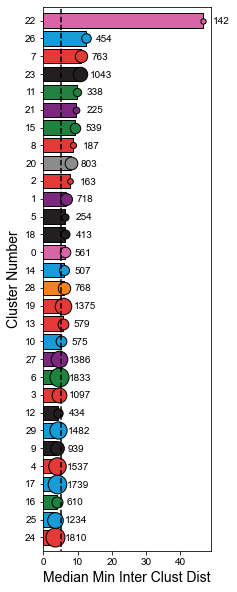

In [6]:
numkclusts=max(fullclusternum)+1
colorhex=['#d865a6','#7c2880','#e23a36','#e23a36','#e23a36','#231f20','#1f8241','#e23a36','#e23a36','#231f20','#189bd7','#1f8241','#231f20','#e23a36','#189bd7','#1f8241','#1f8241','#189bd7','#231f20','#e23a36','#8c8c8c','#7c2880','#d865a6','#231f20','#e23a36','#189bd7','#189bd7','#7c2880','#f58220','#189bd7']

fullhumangoodness=[]
for c in range(0,numkclusts):
    tmpdf=humandf[humandf['Cluster Number']==c]
    fullhumangoodness.append(np.median(tmpdf['Min Inter Clust Dist'].tolist()))
    
print(fullhumangoodness)

tmp = np.argsort(fullhumangoodness)
sort_index2 = tmp #[::-1] 
#sort_index2=[28, 6, 15, 11, 16, 20, 0, 22, 27, 21, 1, 10, 17, 29, 26, 25, 14, 23, 9, 5, 12, 18, 24, 4, 19, 8, 2, 13, 3, 7]
print(sort_index2)

plt.figure(figsize=(3,10))
count=0
for s in sort_index2:
    count=count+1
    plt.barh(count,fullhumangoodness[s],color=colorhex[s],edgecolor='black')
    plt.scatter(fullhumangoodness[s],count,color=colorhex[s],edgecolor='black',s=fullhumancount[s]/5)
    #plt.text(fullhumangoodness[s]+2,count-0.2,str(round(fullhumangoodness[s],1)))
    plt.text(fullhumangoodness[s]+3,count-0.2,str(round(fullhumancount[s],1)))
    #plt.barh(count,fullhumancount[s],color=colorhex[s],edgecolor='black')
    #plt.scatter(fullhumancount[s],count,color=colorhex[s],edgecolor='black',s=fullhumangoodness[s]*20)    
    #plt.text(fullhumangoodness[s]+3,count-0.2,str(round(fullhumancount[s],1)))
    
plt.plot([np.median(fullmininterclustdist),np.median(fullmininterclustdist)],[0,31],'--k')
plt.yticks(np.arange(1,len(sort_index2)+1,1),sort_index2)
plt.ylabel('Cluster Number',fontsize=14)
plt.xlabel('Median Min Inter Clust Dist',fontsize=14)
plt.ylim([0.25,numkclusts+0.75])

#plt.savefig('../../Figures/2024_02/Goodness_Number_in_Clusters_all_human_IDRome_sorted.pdf', transparent=False, bbox_inches = "tight")

In [8]:
dfgoodness=pd.DataFrame()
dfgoodness['GIN Type']=np.arange(0,numkclusts)
dfgoodness['Number of IDRs']=fullhumancount
dfgoodness['Median Min Inter Clust Dist']=fullhumangoodness
dfgoodness=dfgoodness.sort_values(by='Median Min Inter Clust Dist',ascending=False)
print(dfgoodness)

    GIN Type  Number of IDRs  Median Min Inter Clust Dist
22        22             142                    46.533045
26        26             454                    12.356490
7          7             763                    10.947997
23        23            1043                    10.606494
11        11             338                     9.700394
21        21             225                     9.578062
15        15             539                     9.241110
8          8             187                     8.494626
20        20             803                     7.956724
2          2             163                     7.688898
1          1             718                     6.530259
5          5             254                     6.400244
18        18             413                     6.340318
0          0             561                     6.210175
14        14             507                     6.037486
28        28             768                     6.021423
19        19  